In [1]:
# Import all packages needed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import style.json
style_path: Path = Path.cwd().parent / 'style' / 'style.json'
with open(style_path, 'r') as f: # opens the style.json file
    style: dict = json.load(f) # loads as a dictionary object

In [3]:
# Loading Data (data file must be in the same directory as jupyter notebook)
# Import data from excel file
# TODO: replace filename with the name of your data file
raw_data_filename: str ='non-imine iodine doping.csv'

# Tell program to read the data
raw_data: pd.DataFrame = pd.read_csv(raw_data_filename) # read data into a pandas dataframe

# Output data
raw_data

,Baseline 100%T,Unnamed: 1,Baseline 0%T,Unnamed: 3,non-imine undoped,Unnamed: 5,non-imine 10 min iodine doped,Unnamed: 7,non-imine 1 min iodine doped,Unnamed: 9,...,Unnamed: 53,non-imine 10 sec TFA vapour,Unnamed: 55,non-imine 30 sec TFA vapour,Unnamed: 57,non-imine 1min TFA vapour,Unnamed: 59,imine polymer 1 hour FeCl3,Unnamed: 61,Unnamed: 62
0,Wavelength (nm),%T,Wavelength (nm),%T,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,...,Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,Wavelength (nm),Abs,NaN
1,1200,1153.976563,1200,0.07123257965,1200,-0.0142374197,1200,0.005885764956,1200,0.01289197244,...,-0.01585526019,1200,-0.01570783183,1200,-0.01762918755,1200,-0.01652715728,1200,-0.009749501012,NaN
2,1199.333374,1154.07312,1199.333374,0.07214586437,1199.333374,-0.01413560007,1199.333374,0.005917410366,1199.333374,0.01285490859,...,-0.01582096517,1199.333374,-0.01567182876,1199.333374,-0.01749777794,1199.333374,-0.01640259288,1199.333374,-0.009757499211,NaN
3,1198.666626,1153.751221,1198.666626,0.07253429294,1198.666626,-0.01432428788,1198.666626,0.005876214243,1198.666626,0.01277503185,...,-0.01601650752,1198.666626,-0.01571557298,1198.666626,-0.01753402688,1198.666626,-0.01646834239,1198.666626,-0.009895725176,NaN
4,1198,1154.108521,1198,0.07422624528,1198,-0.01409305073,1198,0.006060763262,1198,0.01295002829,...,-0.01583289728,1198,-0.01544380747,1198,-0.0174155701,1198,-0.0163133461,1198,-0.009737048298,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,End Method Modifications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2309,<Current Wavelength>,300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2310,<SBW (nm)>,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2311,<Energy>,91.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data preprocessing specific to UV-Vis
#TODO: baseline correction?
# TODO: normalize as an option
def preprocess(data: pd.DataFrame, normalize: bool = True, baseline: bool = True):
    """Function that applies transformation to the dataframe which will make it ready for plotting. Note, this is specific to UV-Vis.
    """
    # Drop row with index = 0
    data = data.drop(labels=0, axis=0) # drop row with index = 0

    # Drop additional information
    indexes = data[data.columns[0]].str.find("Collection Time:") # find the index of the row with the string "Collection Time:"
    first_occurrence: int = indexes[indexes==0.0].index[0] # find the index of the first occurrence of the string "Collection Time:"
    data = data.drop(labels=range(first_occurrence-3, len(data.index)+1), axis=0) # drop the rows with the additional information

    # Rename column names (y-data)
    column_rename: dict = {}
    for i in range(1, len(data.columns), 2): # loop through every other column
        column_rename[data.columns[i]] = data.columns[i-1] + "_Abs" # rename every other column by adding _Abs
    data = data.rename(columns=column_rename) # rename the columns

    # Rename column name (x-data)
    data = data.rename(columns={data.columns[0]: "Wavelength (nm)"}) # rename the first column to "Wavelength (nm)"

    # Baseline correction
    if baseline: # if baseline is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                data[col] = data[col] - np.average(data[col][0:50]) # subtract the average of the first 50 data points from every absorbance value

    # Normalize absorbance values
    if normalize: # if normalize is True, execute the code below
        for col in data.columns:
            if "Abs" in col:
                max_val: float = data[col].max() # find the maximum absorbance value
                data[col] = data[col] / max_val # divide every absorbance value by the maximum absorbance value
    return data

# NOTE: change True to False if you don't want normalization or baseline correction
preprocessed_data: pd.DataFrame = preprocess(raw_data, False, False)
preprocessed_data

,Wavelength (nm),Baseline 100%T_Abs,Baseline 0%T,Baseline 0%T_Abs,non-imine undoped,non-imine undoped_Abs,non-imine 10 min iodine doped,non-imine 10 min iodine doped_Abs,non-imine 1 min iodine doped,non-imine 1 min iodine doped_Abs,...,non-imine 5 sec TFA vapour_Abs,non-imine 10 sec TFA vapour,non-imine 10 sec TFA vapour_Abs,non-imine 30 sec TFA vapour,non-imine 30 sec TFA vapour_Abs,non-imine 1min TFA vapour,non-imine 1min TFA vapour_Abs,imine polymer 1 hour FeCl3,imine polymer 1 hour FeCl3_Abs,Unnamed: 62
1,1200,1153.976563,1200,0.07123257965,1200,-0.0142374197,1200,0.005885764956,1200,0.01289197244,...,-0.01585526019,1200,-0.01570783183,1200,-0.01762918755,1200,-0.01652715728,1200,-0.009749501012,NaN
2,1199.333374,1154.07312,1199.333374,0.07214586437,1199.333374,-0.01413560007,1199.333374,0.005917410366,1199.333374,0.01285490859,...,-0.01582096517,1199.333374,-0.01567182876,1199.333374,-0.01749777794,1199.333374,-0.01640259288,1199.333374,-0.009757499211,NaN
3,1198.666626,1153.751221,1198.666626,0.07253429294,1198.666626,-0.01432428788,1198.666626,0.005876214243,1198.666626,0.01277503185,...,-0.01601650752,1198.666626,-0.01571557298,1198.666626,-0.01753402688,1198.666626,-0.01646834239,1198.666626,-0.009895725176,NaN
4,1198,1154.108521,1198,0.07422624528,1198,-0.01409305073,1198,0.006060763262,1198,0.01295002829,...,-0.01583289728,1198,-0.01544380747,1198,-0.0174155701,1198,-0.0163133461,1198,-0.009737048298,NaN
5,1197.333374,1153.629639,1197.333374,0.0731908679,1197.333374,-0.01423756965,1197.333374,0.00592654245,1197.333374,0.01294653397,...,-0.01583758928,1197.333374,-0.01563502476,1197.333374,-0.01754243113,1197.333374,-0.01634007134,1197.333374,-0.009840967134,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,303.3332825,1418.676514,303.3332825,-0.000174062443,303.3332825,0.0126449829,303.3332825,0.06954296678,303.3332825,0.04382653907,...,0.01005462185,303.3332825,0.009769287892,303.3332825,0.00960729178,303.3332825,0.01062619779,303.3332825,0.03095588088,NaN
1347,302.666626,1419.682617,302.666626,-1.252697894E-005,302.666626,0.01355379075,302.666626,0.07055941224,302.666626,0.04498747364,...,0.01089561172,302.666626,0.009931715205,302.666626,0.01028330997,302.666626,0.01085890271,302.666626,0.03111285903,NaN
1348,301.9999695,1418.107666,301.9999695,-0.0002732081048,301.9999695,0.0125419097,301.9999695,0.07051208615,301.9999695,0.0448295325,...,0.01016873959,301.9999695,0.008838661946,301.9999695,0.00997515209,301.9999695,0.01005311217,301.9999695,0.02899715118,NaN
1349,301.3332825,1417.099243,301.3332825,-0.001400015433,301.3332825,0.01221380103,301.3332825,0.07089859992,301.3332825,0.04540191591,...,0.009733098559,301.3332825,0.009565796703,301.3332825,0.009738975205,301.3332825,0.01076442562,301.3332825,0.02816047892,NaN


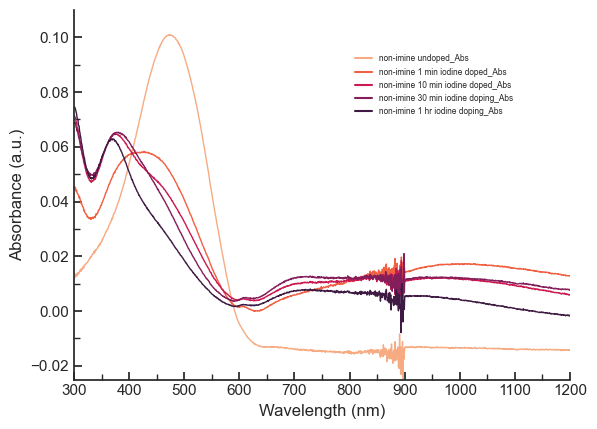

In [8]:
# Plot the data!
# NOTE: User must change the sample names to the correct column names.
sample_name_to_plot: list[str] = [
    "non-imine undoped_Abs",
    "non-imine 1 min iodine doped_Abs",
    "non-imine 10 min iodine doped_Abs",
    "non-imine 30 min iodine doping_Abs",
    "non-imine 1 hr iodine doping_Abs"
]

# If you want to rename, uncomment and insert here!
# sample_name_rename: dict = {"2023_06_22_C10-dialdehyde-chcl3_Abs": "RENAME", "2023_06_22_benzene-diphosphonate1_Abs": "RENAME", "2023_06_22_fluorene-diphosphonate_Abs": "RENAME", "2023_06_22_model-compound_Abs" : "RENAME", "2023_06_22_AU-038-A2-3_Abs" : "RENAME"}
# preprocessed_data = preprocessed_data.rename(columns=sample_name_rename)
# Convert to "tidy" form
plot_data: pd.DataFrame = pd.melt(
    preprocessed_data,
    id_vars=["Wavelength (nm)"],
    value_vars=sample_name_to_plot,
    var_name="sample",
    value_name="Absorbance (a.u.)",
)

# Set correct dtypes
plot_data = plot_data.astype(
    {"Wavelength (nm)": "float32", "sample": "str", "Absorbance (a.u.)": "float32"}
)

# seaborn styles
sns.set_style("ticks")
sns.set_context("notebook") # gives the blank white background theme
# sns.set_theme(context="notebook", style="white", font="Helvetica")

graph = sns.lineplot(
    data=plot_data, # refers to dataframe that contains the data
    x="Wavelength (nm)", # refers to column header to get all the X data
    y="Absorbance (a.u.)", # refers to column header to get all the Y data
    hue="sample",
    palette="rocket_r",  #NOTE: User can change the palette here
    linewidth=style["graph"]["default"]["line_thickness"], # refers to the thickness of the line in the graph (this is set in the style.json file)
)
sns.despine() # this removes the top and right spines of the graph

graph.legend(
    fontsize=style["legend"]["font_size"], # refers to the font size of the legend (this is set in the style.json file)
    bbox_to_anchor=(0.9, 0.9), # refers to the position of the legend anchored in the figure
    title_fontsize=style["legend"]["title_font_size"], # refers to the font size of the legend title
    shadow=False, # refers to whether the legend has a shadow or not
    frameon=False, # refers to whether the legend has a frame or not
)
# font family
plt.rcParams['font.family'] = style["graph"]["default"]["font_family"] # refers to the font family of the text in the graph (this is set in the style.json file)

# y-axis and x-axis ticks
graph.xaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in X-axis
graph.yaxis.set_minor_locator(AutoMinorLocator(2)) # value of AutoMinorLocator dictates number of minor ticks between major ticks in Y-axis
graph.tick_params(axis="y", direction="in") # direction of major ticks in Y-axis
graph.tick_params(axis="x", direction="in") # direction of major ticks in X-axis
graph.tick_params(axis="y", which="minor", length=4, direction="in") # direction and length of minor ticks in Y-axis
graph.tick_params(axis="x", which="minor", length=4, direction="in") # direction and length of minor ticks in X-axis

# NOTE: User can change the x and y limits here
plt.xlim(300, 1200)
# NOTE: User can change the y limits here
plt.ylim(-0.025, 0.11)

# Save the figure
# NOTE: User can change the filename
plt.savefig("2024_09_03 non-imine polymer iodine doping solid state.svg", dpi=300, bbox_inches="tight")
plt.savefig("2024_09_03 non-imine polymer iodine doping solid state.jpg", dpi=300, bbox_inches="tight")
